In [1]:
from load_data import *
import pingouin as pg

usedTestSubjs = behavior.query("(session=='experiment') & (condType in @condTypes) & ~excluded").subjectId.unique()
expTrials = behavior.query("(session=='experiment') & (subjectId in @usedTestSubjs)").reset_index(drop=True)

(Re)loading load_data


In [2]:
def learningColumn(behavior):
    lastSubject = None
    learning = True
    column = []
    for _, row in behavior.iterrows():
        assert row.session == 'experiment'
        if row.condType != 'filler':
            learning = False
        column.append(learning)
        if lastSubject != row.subjectId or row.condType == 'blush':
            learning = True
            lastSubject = row.subjectId
    return column

expTrials['learning'] = learningColumn(expTrials)
expTrials.query('learning').condType.unique()

array(['filler'], dtype=object)

In [3]:
print('Proportions of filler trials when the subjects had to learn the preferred side (learning trials)')
expTrials.query("condType=='filler'").groupby('subjectId').learning.mean().agg(['min', 'median', 'mean', 'max'])

Proportions of filler trials when the subjects had to learn the preferred side (learning trials)


min       0.181548
median    0.276018
mean      0.277135
max       0.349558
Name: learning, dtype: float64

In [4]:
bkey = ['subjectId', 'session', 'trialCount']
skey = ['subjectId', 'session', 'Trial']
times = expTrials.set_index(bkey)
times['trialTime'] = samples.groupby(skey).Time.max() - samples.groupby(skey).Time.min() + pd.to_timedelta('20ms')
times['responseTime'] = times.trialTime / pd.to_timedelta('1s') - times.condType.apply(lambda condType: 1. if condType=='filler' else 7.)
times = times.reset_index()

In [5]:
print('Subject median response times in learning trials')
learningRT = times.query('learning').groupby('subjectId').responseTime.median()
learningRT.agg(['min', 'median', 'mean', 'max'])

Subject median response times in learning trials


min       0.160000
median    0.360000
mean      0.396456
max       1.100000
Name: responseTime, dtype: float64

In [6]:
print('Subject median response times in non-learning filler trials')
nonLearningRT = times.query("~learning & condType=='filler'").groupby('subjectId').responseTime.median()
nonLearningRT.agg(['min', 'median', 'mean', 'max'])

Subject median response times in non-learning filler trials


min       0.140000
median    0.340000
mean      0.378354
max       0.920000
Name: responseTime, dtype: float64

(array([ 4.,  5., 15., 25.,  7.,  8.,  6.,  2.,  1.,  3.,  0.,  1.,  1.,
         1.]),
 array([0.14      , 0.19571429, 0.25142857, 0.30714286, 0.36285714,
        0.41857143, 0.47428571, 0.53      , 0.58571429, 0.64142857,
        0.69714286, 0.75285714, 0.80857143, 0.86428571, 0.92      ]),
 <BarContainer object of 14 artists>)

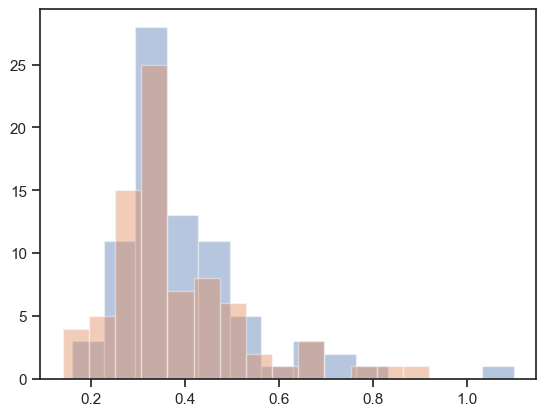

In [7]:
plt.hist(learningRT, bins='auto', alpha=0.4)
plt.hist(nonLearningRT, bins='auto', alpha=0.4)

In [8]:
testTrials = expTrials.query("condType in @condTypes")
pupils = samples.merge(testTrials, left_on=['subjectId', 'session', 'Trial'], right_on=['subjectId', 'session', 'trialCount'])
corrPupils = baselineCorrect(pupils)

In [9]:
fields = ['subjectId', 'condType', 'trialCount']
pp = pd.DataFrame()
for field, startTime, endTime in [('earlyPupil', '1s', '2s'), ('latePupil', '3s', '4s')]:
    response = corrPupils[corrPupils.offsetFromStim.between(pd.to_timedelta(startTime), pd.to_timedelta(endTime))]
    pp[field] = response.groupby(fields).Pupil.mean().groupby(fields[:-1]).mean()
pp = pp.unstack('condType')

In [10]:
pp['learningRT'] = learningRT
pp['nonLearningRT'] = nonLearningRT

In [11]:
excSubjects = getExcSubjects()

Subjects not selecting the preferred option in more than half of both normal and wink trials:
	 [4006, 5008, 5015, 5033, 5034, 5038, 5041, 5047, 8001, 8006, 8016, 8020, 8021, 8025]


In [12]:
def correlateRT(pp, field, condType1, condType2, learning=True):
    if learning:
        x = pp.learningRT
        plt.xlabel('Mean response time in learning trials [sec]')
    else:
        x = pp.nonLearningRT
        plt.xlabel('Mean response time in non-learning filler trials [sec]')
    y = pp[field][condType1] - pp[field][condType2]
    plt.ylabel(f'Difference in {field}\nbetween {condType1} and {condType2} conditions [mm]')
    plt.scatter(x, y, alpha=0.5)
    plt.show()
    return pg.corr(x, y, method='spearman')

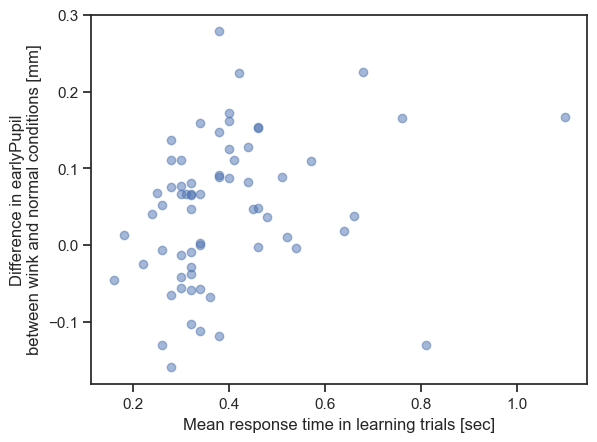

,n,r,CI95%,p-val,power
spearman,65,0.361191,"[0.13, 0.56]",0.003117,0.850494


In [13]:
correlateRT(pp.query('subjectId not in @excSubjects'), 'earlyPupil', 'wink', 'normal')

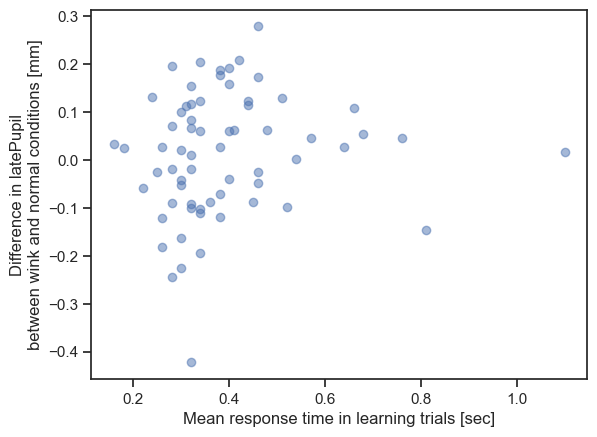

,n,r,CI95%,p-val,power
spearman,65,0.213489,"[-0.03, 0.43]",0.087719,0.404644


In [14]:
correlateRT(pp.query('subjectId not in @excSubjects'), 'latePupil', 'wink', 'normal')

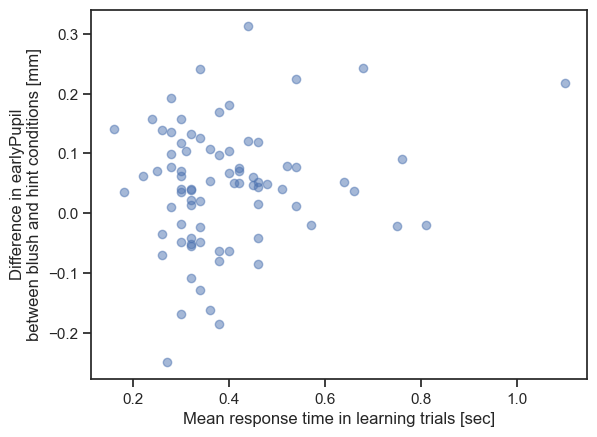

,n,r,CI95%,p-val,power
spearman,79,0.048517,"[-0.17, 0.27]",0.671123,0.070786


In [15]:
correlateRT(pp, 'earlyPupil', 'blush', 'hint')

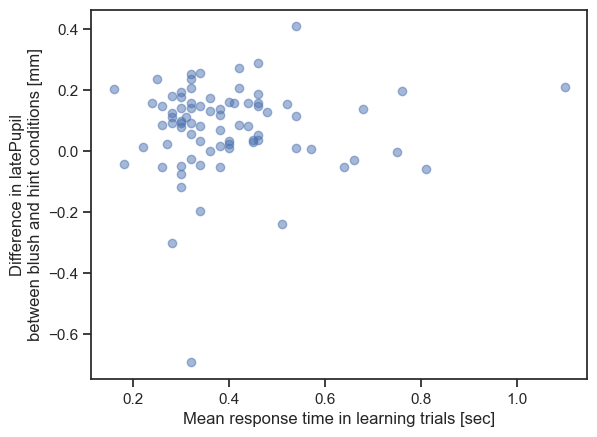

,n,r,CI95%,p-val,power
spearman,79,0.020141,"[-0.2, 0.24]",0.860149,0.053376


In [16]:
correlateRT(pp, 'latePupil', 'blush', 'hint')

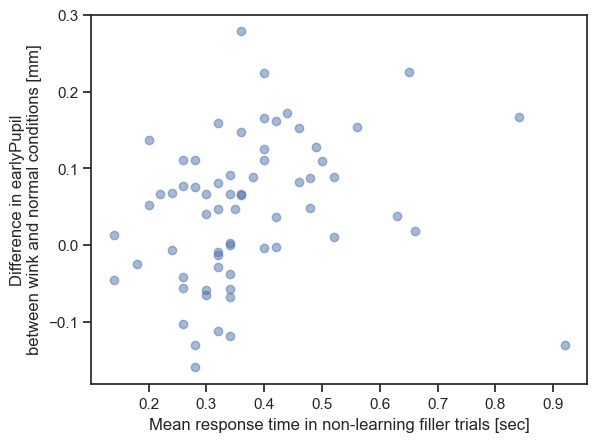

,n,r,CI95%,p-val,power
spearman,65,0.381995,"[0.15, 0.57]",0.00169,0.890632


In [17]:
correlateRT(pp.query('subjectId not in @excSubjects'), 'earlyPupil', 'wink', 'normal', learning=False)

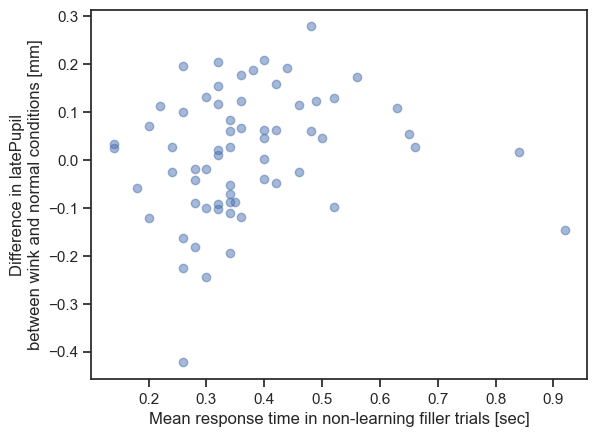

,n,r,CI95%,p-val,power
spearman,65,0.285872,"[0.05, 0.5]",0.020974,0.644691


In [18]:
correlateRT(pp.query('subjectId not in @excSubjects'), 'latePupil', 'wink', 'normal', learning=False)

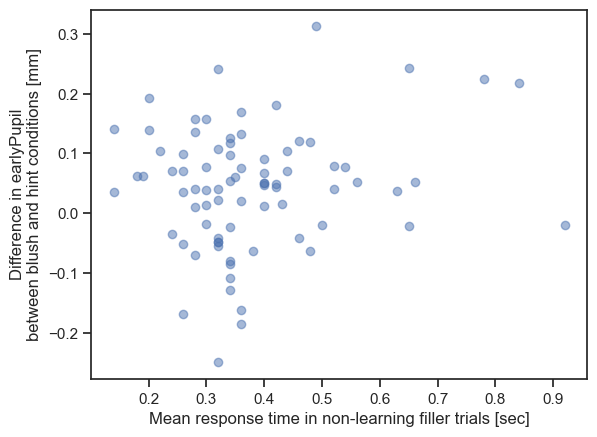

,n,r,CI95%,p-val,power
spearman,79,0.07221,"[-0.15, 0.29]",0.527115,0.09696


In [19]:
correlateRT(pp, 'earlyPupil', 'blush', 'hint', learning=False)

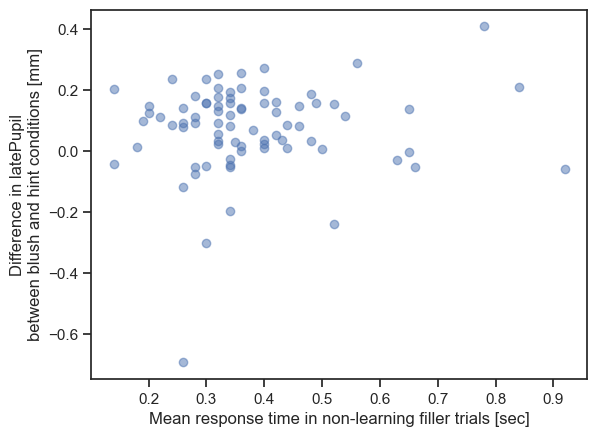

,n,r,CI95%,p-val,power
spearman,79,0.033501,"[-0.19, 0.25]",0.769449,0.059737


In [20]:
correlateRT(pp, 'latePupil', 'blush', 'hint', learning=False)

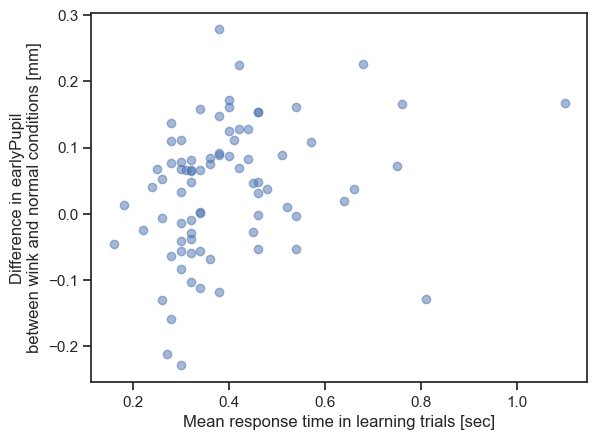

,n,r,CI95%,p-val,power
spearman,79,0.351759,"[0.14, 0.53]",0.001478,0.896405


In [21]:
correlateRT(pp, 'earlyPupil', 'wink', 'normal')

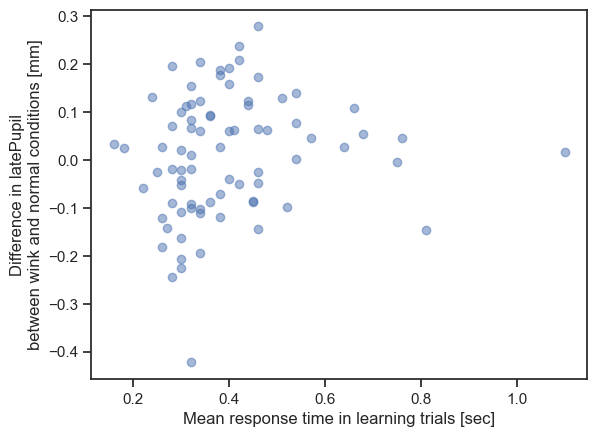

,n,r,CI95%,p-val,power
spearman,79,0.244026,"[0.02, 0.44]",0.030215,0.588298


In [22]:
correlateRT(pp, 'latePupil', 'wink', 'normal')

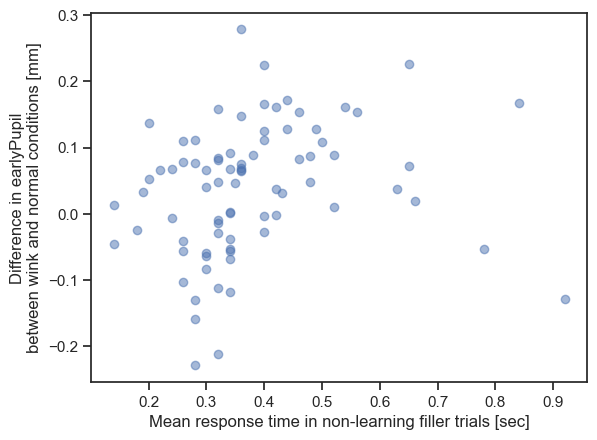

,n,r,CI95%,p-val,power
spearman,79,0.377912,"[0.17, 0.55]",0.000595,0.936473


In [23]:
correlateRT(pp, 'earlyPupil', 'wink', 'normal', learning=False)

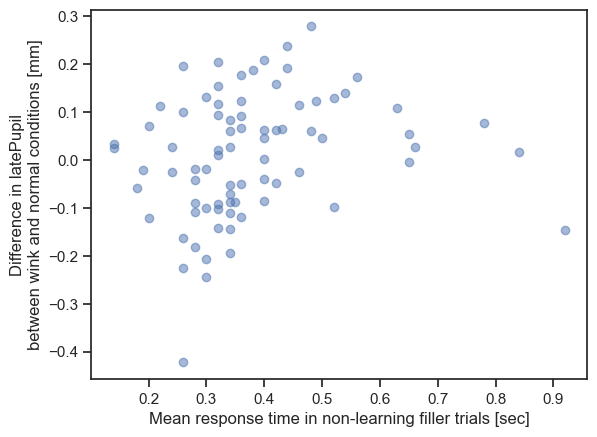

,n,r,CI95%,p-val,power
spearman,79,0.326905,"[0.11, 0.51]",0.003277,0.844958


In [24]:
correlateRT(pp, 'latePupil', 'wink', 'normal', learning=False)